# Nonlinear bias using generalized tracers and power spectra
This example showcases how to do nonlinear biasing with the generalized tracers and 2D power spectra implemented in CCL. First we show how this is done explicitly with most functions outside of CCL. Then we show the CCL functionality that does the same thing. We could use a comparison like this as a unit test in the future.

For more on generalized tracers and power spectra, see GeneralizedTracers.ipynb

In [1]:
import numpy as np
import pylab as plt
import pyccl as ccl
import pyccl.nl_pt as pt
%matplotlib inline

Note that the perturbation theory functionality lives within `pyccl.nl_pt`.

## Preliminaries
Let's just begin by setting up a cosmology and some biases

In [2]:
# Cosmology
cosmo = ccl.Cosmology(Omega_c=0.27, Omega_b=0.045, h=0.67, A_s=2.1e-9, n_s=0.96)

# Biases for number counts 
b_1 = 2.0 # constant values for now
b_2 = 1.0
b_s = 1.0

# Biases for IAs
c_1 = 1.
c_2 = 0.5
c_d = 0.5

## PT tracers
Power spectra are Fourier-space correlations between two quantities. In CCL the quantities you want to correlate are defined in terms of so-called `PTTracers`. Here we create two of them, one for number counts (galaxy clustering), one for intrinsic alignments and one for matter.

In [3]:
# Number counts
ptt_g = pt.PTNumberCountsTracer(b1=b_1, b2=b_2, bs=b_s)

# Intrinsic alignments
ptt_i = pt.PTIntrinsicAlignmentTracer(c1=c_1, c2=c_2, cdelta=c_d)

# Matter
ptt_m = pt.PTMatterTracer()

# Note that we've assumed constant biases for simplicity, but you can also make them scale-dependent:
z = np.linspace(0,1,128)
bz = b_1 / ccl.growth_factor(cosmo, 1./(1+z))
ptt_g_b = pt.PTNumberCountsTracer(b1=(z, bz))

## PT calculator
Another object, `PTWorkspace` takes care of initializing FastPT (essentially precomputing some of the stuff it needs to get you PT power spectra). You'll need one of these before you can compute P(k)s.

In [4]:
# The `with_NC` and `with_IA` flags will tell FastPT to initialize the right things.
# `log10k_min/max and nk_per_decade will define the sampling in k you should use.
ptc = pt.PTCalculator(with_NC=True, with_IA=True,
                      log10k_min=-4, log10k_max=2, nk_per_decade=20)

## PT power spectra
Let's compute some power spectra! We do so by calling `get_pt_pk2d` with whatever tracers you want to cross-correlate. This will return a `Pk2D` object that you can then evaluate at whatever scale and redshift you want.

In [5]:
# Galaxies x galaxies
pk_gg = pt.get_pt_pk2d(cosmo, ptt_g, tracer2=ptt_g, ptc=ptc)

# Galaxies x matter
pk_gm = pt.get_pt_pk2d(cosmo, ptt_g, tracer2=ptt_m, ptc=ptc)

# Galaxies x IAs
pk_gi = pt.get_pt_pk2d(cosmo, ptt_g, tracer2=ptt_i, ptc=ptc)

# IAs x IAs
pk_ii = pt.get_pt_pk2d(cosmo, ptt_i, tracer2=ptt_i, ptc=ptc)

# IAs x matter
pk_im = pt.get_pt_pk2d(cosmo, ptt_i, tracer2=ptt_m, ptc=ptc)

# Matter x matter
pk_mm = pt.get_pt_pk2d(cosmo, ptt_m, tracer2=ptt_m, ptc=ptc)


/home/alonso/.local/lib/python3.6/site-packages/pyccl-2.0.2.dev128+g40a5d4e.d20200213-py3.6.egg/pyccl/nl_pt/power.py:281: UserWarning: The full non-linear model for the cross-correlation between number counts and intrinsic alignments is still work in progress in FastPT. As a workaround CCL assumes a non-linear treatment of IAs, but only linearly biased number counts.
  "The full non-linear model for the cross-correlation "


**Note the warning above!** FastPT is not yet able to compute IAs x galaxies in a consistent way. What CCL does is to use the full non-linear model for IAs, but use a linear bias for galaxies.

OK, let's now plot a few of these!

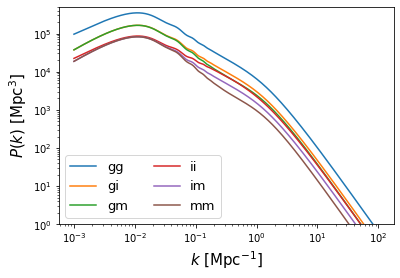

In [6]:
# Let's plot everything at z=0

ks = np.logspace(-3,2,512)
ps = {}
ps['gg'] = pk_gg.eval(ks, 1., cosmo)
ps['gi'] = pk_gi.eval(ks, 1., cosmo)
ps['gm'] = pk_gm.eval(ks, 1., cosmo)
ps['ii'] = pk_ii.eval(ks, 1., cosmo)
ps['im'] = pk_im.eval(ks, 1., cosmo)
ps['mm'] = pk_mm.eval(ks, 1., cosmo)

plt.figure()
for pn, p in ps.items():
    plt.plot(ks, p, label=pn)
plt.loglog()
plt.legend(loc='lower left', ncol=2, fontsize=13)
plt.ylim([1E0, 5E5])
plt.xlabel(r'$k\,\,[{\rm Mpc}^{-1}]$', fontsize=15)
plt.ylabel(r'$P(k)\,\,[{\rm Mpc}^{3}]$', fontsize=15)
plt.show()

## Angular power spectra
We can now use these P(k)s to compute angular power spectra, passing them to `ccl.angular_cl`.
Let's illustrate this specifically for the usual 3x2pt. We will define two standard tracers (not `PTTracer`s, but the ones used to compute angular power spectra) for number counts and weak lensing. The first one will be associated with our `PTNumberCountsTracer`, and the latter with out `PTMatterTracer`.

In [7]:
z = np.linspace(0, 1.5, 1024)
nz = np.exp(-((z-0.7)/0.1)**2)

# We give this one a bias of 1, since we've taken care of galaxy bias at the P(k) level.
t_g = ccl.NumberCountsTracer(cosmo, False, dndz=(z, nz), bias=(z, np.ones_like(z)))

# Lensing
t_l = ccl.WeakLensingTracer(cosmo, dndz=(z, nz))

Now compute power spectra. Note how we pass the P(k)s we just calculated as `p_of_k_a`.

In [8]:
ell = np.unique(np.geomspace(2,1000,100).astype(int)).astype(float)
cls={}
cls['gg'] = ccl.angular_cl(cosmo, t_g, t_g, ell, p_of_k_a=pk_gg)
cls['gl'] = ccl.angular_cl(cosmo, t_g, t_l, ell, p_of_k_a=pk_gm)
cls['ll'] = ccl.angular_cl(cosmo, t_l, t_l, ell, p_of_k_a=pk_mm)

Plot away!

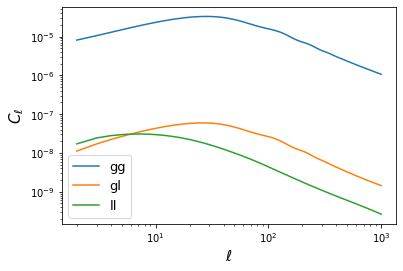

In [9]:
plt.figure()
for cn, c in cls.items():
    plt.plot(ell, c, label=cn)
plt.loglog()
plt.legend(loc='lower left', ncol=1, fontsize=13)
plt.xlabel(r'$\ell$', fontsize=15)
plt.ylabel(r'$C_\ell$', fontsize=15)
plt.show()
